In [28]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import string

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

import pickle

In [2]:
file_name = '../output/sample_full.csv' 
df = pd.read_csv(file_name, index_col=0).reset_index(drop=True)
df.head() # print the first 5 rows

,location,company_name,job_title,summary,full_info
0,London,Lewisham Council,Finance and Admin Officer,Job type: full-time 35 hours.\nTo provide Fina...,Job Ref: RES-20-003\nJob type: full-time 35 ho...
1,London,"UK Government - Department for Business, Energ...",International Climate Finance Communications a...,This will entail effectively responding to bri...,Communications is an increasingly significant ...
2,London,Nucleus Central,Assistant Finance Project Analyst,"Working within the Finance department, you wil...",Nucleus Global is comprised of the medical com...
3,London,BNP Paribas,London - Graduate Analyst Programme 2020 - Tra...,The Group helps them realise their personal an...,WHO WE ARE\nThe bank for a changing world. BNP...
4,London,Harrington-Leigh,Trainee Mortgage & Protection Advisor - REMOTE...,We are looking to take on Individuals with no ...,Trainee Mortgage & Protection Advisor Main tas...


# EDA 0.0

In [3]:
# check for missing values
df.isnull().mean().sort_values(ascending=False)

full_info       0.0
summary         0.0
job_title       0.0
company_name    0.0
location        0.0
dtype: float64

In [4]:
print(df.shape)
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)
print(df.shape)
df.describe()

(1190, 5)
(733, 5)


,location,company_name,job_title,summary,full_info
count,733,733,733,733,733
unique,98,250,276,350,574
top,London,Capital Index,Accounts Payable Specialist,Be available to support regular seminars offer...,Role Description:\nActively contribute to the ...
freq,545,57,106,57,4


In [5]:
df_title = pd.DataFrame(df.job_title.value_counts()).reset_index()
df_title.columns = ['job_title', 'frequency']
df_title

,job_title,frequency
0,Accounts Payable Specialist,106
1,Finance Manager,100
2,Junior KYC and On-boarding Analyst,57
3,Financial Accountant,57
4,Finance Director,21
...,...,...
271,Global Equity Analyst (Intern Position) – Mark...,1
272,Revenue Analyst - Finance,1
273,Financial Accountant - 12 months plus experience,1
274,Commercial Analyst (Provider Focus),1


/Users/oren/opt/anaconda3/envs/SMM694_NLP/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  after removing the cwd from sys.path.


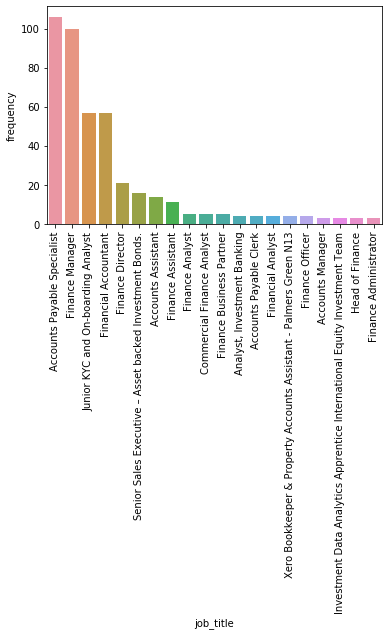

In [6]:
sns.barplot(x="job_title", y = 'frequency', data=df_title.iloc[0:20])

plt.xticks(rotation=90)
plt.tight_layout()

In [7]:
df.full_info[0]

"Job Ref: RES-20-003\nJob type: full-time 35 hours\nClosing date: Sunday 10 May 2020\nContract Type: Permanent\nSalary: £24,054 - £24,927 pa (Scale 4)\n\nThe role\n\nTo provide Finance Support through raising Purchase Orders, process invoices/ bills, setting up new suppliers and handle related enquiries and administration.\n\nBe responsible for authenticating invoices and payments in accordance with the Council’s financial procedures and regulations.\n\nOrder and issue stationery, supplies and other equipment (including service-specific items) when requested, following standard approval processes and ensure the safe and secure storage of items.\n\nReceipt deliveries and check goods received against purchase order forms.\n\nTo provide an effective and efficient administration support service as part of the Customer Service Centre.\n\nLocation\n\nLaurence House, Catford\n\nWhat we’re looking for\n\nWe are looking for a person who has the ability to work accurately and quickly to meet dea

In [8]:
df.full_info[1]

"Communications is an increasingly significant part of the team’s remit underpinning our strategic objectives at a time of strong public momentum to tackle climate change. Communications Officer will be supporting the team to implement ICF Communications Plan, leading on a number of deliverables and helping to build confidence in the value and integrity of ICF programming. It’s more important than ever before to increase awareness and understanding of what we do and why we do it – both internally and externally in order to maximise support for international climate action, particularly in the run up to COP26 and beyond.\n\n\nThe successful candidate will work on a range of proactive and reactive tasks alongside programme and policy colleagues from across ICF, the wider BEIS International Climate and Energy Directorate, COP26 Unit and other government departments. This will entail effectively responding to briefing requests and providing strategic communications contributions in support

# Data Cleaning

## remove punctuations

In [9]:
def remove_punctuation(text):
    res = ''.join([c for c in text if c not in string.punctuation])
    return res

In [10]:
df_clean = df.copy()
rmv_ls = ['\n', '$', '£']
for c in rmv_ls:
    df_clean['full_info'] = df_clean['full_info'].str.replace(c, '')
df_clean['full_info'] = df_clean['full_info'].apply(lambda x: remove_punctuation(x))
df_clean.full_info[0]

'Job Ref RES20003Job type fulltime 35 hoursClosing date Sunday 10 May 2020Contract Type PermanentSalary 24054  24927 pa Scale 4The roleTo provide Finance Support through raising Purchase Orders process invoices bills setting up new suppliers and handle related enquiries and administrationBe responsible for authenticating invoices and payments in accordance with the Council’s financial procedures and regulationsOrder and issue stationery supplies and other equipment including servicespecific items when requested following standard approval processes and ensure the safe and secure storage of itemsReceipt deliveries and check goods received against purchase order formsTo provide an effective and efficient administration support service as part of the Customer Service CentreLocationLaurence House CatfordWhat we’re looking forWe are looking for a person who has the ability to work accurately and quickly to meet deadlines with good communication skills and is eager to contribute to the teamI

## Expand contractions

In [11]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df_clean['full_info'] = df_clean['full_info'].apply(lambda x: expand_contractions(x))


In [12]:
df_clean['full_info'][0]

'Job Ref RES20003Job type fulltime 35 hoursClosing date Sunday 10 May 2020Contract Type PermanentSalary 24054  24927 pa Scale 4The roleTo provide Finance Support through raising Purchase Orders process invoices bills setting up new suppliers and handle related enquiries and administrationBe responsible for authenticating invoices and payments in accordance with the Council’s financial procedures and regulationsOrder and issue stationery supplies and other equipment including servicespecific items when requested following standard approval processes and ensure the safe and secure storage of itemsReceipt deliveries and check goods received against purchase order formsTo provide an effective and efficient administration support service as part of the Customer Service CentreLocationLaurence House CatfordWhat we’re looking forWe are looking for a person who has the ability to work accurately and quickly to meet deadlines with good communication skills and is eager to contribute to the teamI

## Tokenize

In [13]:
tokenizer = RegexpTokenizer(r'\w+')
df_clean['full_info'] = df_clean['full_info'].apply(lambda x: tokenizer.tokenize(x.lower()))
df_clean['full_info'].head()

0    [job, ref, res20003job, type, fulltime, 35, ho...
1    [communications, is, an, increasingly, signifi...
2    [nucleus, global, is, comprised, of, the, medi...
3    [who, we, arethe, bank, for, a, changing, worl...
4    [trainee, mortgage, protection, advisor, main,...
Name: full_info, dtype: object

In [14]:
df_clean['full_info'][0]

['job',
 'ref',
 'res20003job',
 'type',
 'fulltime',
 '35',
 'hoursclosing',
 'date',
 'sunday',
 '10',
 'may',
 '2020contract',
 'type',
 'permanentsalary',
 '24054',
 '24927',
 'pa',
 'scale',
 '4the',
 'roleto',
 'provide',
 'finance',
 'support',
 'through',
 'raising',
 'purchase',
 'orders',
 'process',
 'invoices',
 'bills',
 'setting',
 'up',
 'new',
 'suppliers',
 'and',
 'handle',
 'related',
 'enquiries',
 'and',
 'administrationbe',
 'responsible',
 'for',
 'authenticating',
 'invoices',
 'and',
 'payments',
 'in',
 'accordance',
 'with',
 'the',
 'council',
 's',
 'financial',
 'procedures',
 'and',
 'regulationsorder',
 'and',
 'issue',
 'stationery',
 'supplies',
 'and',
 'other',
 'equipment',
 'including',
 'servicespecific',
 'items',
 'when',
 'requested',
 'following',
 'standard',
 'approval',
 'processes',
 'and',
 'ensure',
 'the',
 'safe',
 'and',
 'secure',
 'storage',
 'of',
 'itemsreceipt',
 'deliveries',
 'and',
 'check',
 'goods',
 'received',
 'against',


## Remove stop words

In [15]:
def remove_stopwords(text):
    res = [w for w in text if w not in stopwords.words('english')]
    return res

In [16]:
df_clean['full_info'] = df_clean['full_info'].apply(lambda x: remove_stopwords(x))
df_clean['full_info'][0]

['job',
 'ref',
 'res20003job',
 'type',
 'fulltime',
 '35',
 'hoursclosing',
 'date',
 'sunday',
 '10',
 'may',
 '2020contract',
 'type',
 'permanentsalary',
 '24054',
 '24927',
 'pa',
 'scale',
 '4the',
 'roleto',
 'provide',
 'finance',
 'support',
 'raising',
 'purchase',
 'orders',
 'process',
 'invoices',
 'bills',
 'setting',
 'new',
 'suppliers',
 'handle',
 'related',
 'enquiries',
 'administrationbe',
 'responsible',
 'authenticating',
 'invoices',
 'payments',
 'accordance',
 'council',
 'financial',
 'procedures',
 'regulationsorder',
 'issue',
 'stationery',
 'supplies',
 'equipment',
 'including',
 'servicespecific',
 'items',
 'requested',
 'following',
 'standard',
 'approval',
 'processes',
 'ensure',
 'safe',
 'secure',
 'storage',
 'itemsreceipt',
 'deliveries',
 'check',
 'goods',
 'received',
 'purchase',
 'order',
 'formsto',
 'provide',
 'effective',
 'efficient',
 'administration',
 'support',
 'service',
 'part',
 'customer',
 'service',
 'centrelocationlaurenc

## Stemming and Lemmatizing

In [17]:
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    res = [lemmatizer.lemmatize(w) for w in text] 
    return res

In [18]:
stemmer = PorterStemmer()

def word_stemmer(text):
    res = ' '.join([stemmer.stem(w) for w in text])
    return res

In [19]:
df_clean['lemm'] = df_clean['full_info'].apply(lambda x: word_lemmatizer(x))

In [20]:
df_clean['stem'] = df_clean['full_info'].apply(lambda x: word_stemmer(x))

In [25]:
df_clean.head()

,location,company_name,job_title,summary,full_info,lemm,stem
0,London,Lewisham Council,Finance and Admin Officer,Job type: full-time 35 hours.\nTo provide Fina...,"[job, ref, res20003job, type, fulltime, 35, ho...","[job, ref, res20003job, type, fulltime, 35, ho...",job ref res20003job type fulltim 35 hoursclos ...
1,London,"UK Government - Department for Business, Energ...",International Climate Finance Communications a...,This will entail effectively responding to bri...,"[communications, increasingly, significant, pa...","[communication, increasingly, significant, par...",commun increasingli signific part team remit u...
2,London,Nucleus Central,Assistant Finance Project Analyst,"Working within the Finance department, you wil...","[nucleus, global, comprised, medical, communic...","[nucleus, global, comprised, medical, communic...",nucleu global compris medic commun agenc medit...
3,London,BNP Paribas,London - Graduate Analyst Programme 2020 - Tra...,The Group helps them realise their personal an...,"[arethe, bank, changing, world, bnp, paribas, ...","[arethe, bank, changing, world, bnp, paribas, ...",areth bank chang world bnp pariba recogn 2019 ...
4,London,Harrington-Leigh,Trainee Mortgage & Protection Advisor - REMOTE...,We are looking to take on Individuals with no ...,"[trainee, mortgage, protection, advisor, main,...","[trainee, mortgage, protection, advisor, main,...",traine mortgag protect advisor main task duti ...


In [26]:
df_clean_gbt= df_clean[['job_title','stem']].groupby(by='job_title').agg(lambda x:' '.join(x))
df_clean_gbt.reset_index()
df_clean_gbt.head()

,stem
job_title,
ABS Underwriting Analyst (London),job detailsar experienc account payabl clerk m...
ACA; Finance Consultancy,locationlondon unit kingdomsectorbusi analysi ...
Account Manager,project accountanttgfigbil02110616descriptiona...
Account Manager – Healthcare,taketwo interact look experienc fpa analyst jo...
Accountant,french invest properti consult positionsext pr...


In [30]:
# save df_clean
dirPData = '../data/'
f_name = dirPData + 'df_clean.pickle'
with open(f_name, "wb") as f:
    pickle.dump(df_clean, f)

## Document Term Matrix

In [65]:
# Creating Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer 
cv = CountVectorizer(analyzer='word')
data = cv.fit_transform(df_clean_gbt['full_info'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index = df_clean_gbt.index
df_dtm.shape

(276, 18297)

## Wordcloud

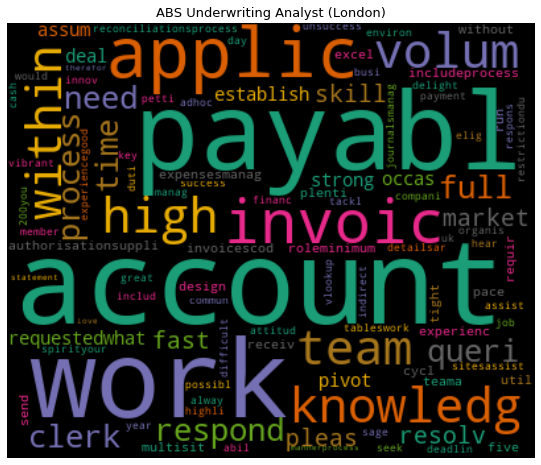

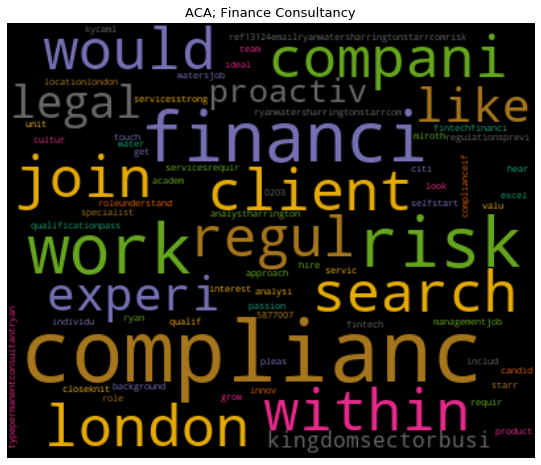

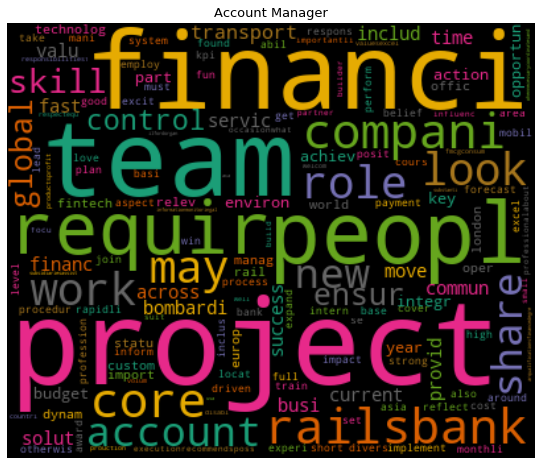

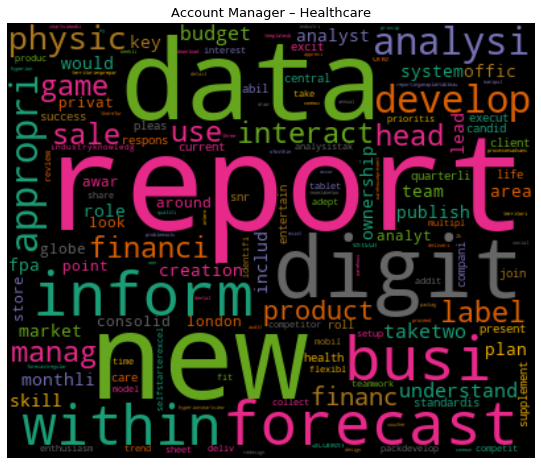

In [66]:
# Function for generating word clouds
def generate_wordcloud(data,title):
    wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('\n'.join(wrap(title,60)),fontsize=13)
    plt.show()

# Transposing document term matrix
df_dtm = df_dtm.transpose()

# Plotting word cloud for each product
for index, job_title in enumerate(df_dtm.columns[0:4]):
    generate_wordcloud(df_dtm[job_title].sort_values(ascending=False),job_title)

In [60]:
df_dtm_t.columns[0:4]

Index(['ABS Underwriting Analyst (London)', 'ACA; Finance Consultancy',
       'Account Manager', 'Account Manager – Healthcare'],
      dtype='object', name='job_title')

## Readability

In [68]:
# import textstat
# require python 3.5
# df['dale_chall_score'] = df_clean['full_info'].apply(lambda x: 
#                                                   textstat.dale_chall_readability_score(x))
# df['flesh_reading_ease'] = df_clean['full_info'].apply(lambda x: 
#                                                   textstat.flesch_reading_ease(x))
# df['gunning_fog'] = df_clean['full_info'].apply(lambda x: 
#                                            textstat.gunning_fog(x))

# print('Dale Chall Score : ',df_clean[df_clean['full_info'] > 1]['dale_chall_score'].mean())
# print('Flesch Reading Score : ',df_clean[df_clean['full_info'] > 1]['flesh_reading_ease'].mean())
# print('Gunning Fog Index : ',df_clean[df_clean['full_info'] > 1]['gunning_fog'].mean())
